# Bandits exploration

Setup: multiple one-armed bandits with unknown probability of winning.
Goal: maximize winnings (i.e. figure out the best bandit and avoid playing suboptimal ones).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

%matplotlib inline

In [2]:
class Bandit:
    '''
    One-armed bandit with a probability P(winning) = p
    '''
    def __init__(self):
        self.p = np.random.random()
        self.num_trials = 0
        self.expectation = 0.5
        
    def get_p(self): return self.p
    def get_num_trials(self): return self.num_trials
    def get_expectation(self): return self.expectation
    
    def update_expectation(self, result):
        self.expectation = (1 - 1 / self.num_trials) * self.expectation + 1 / self.num_trials * result 
    
    def pull(self):
        result = 1 if np.random.random() < self.p else 0
        
        self.num_trials += 1
        self.update_expectation(result)
        
        return result

### Traditional A/B testing: exploring each bandit equally

Set up three bandits, play each one 100 times and figure out the percentage of winning for each of those. This approach is called A/B testing. Notice: you want to determine ahead of time how many trials you need to establish statistically significant differences. One problem with this is that you need more trials when the differences are small!

In [3]:
num_bandits = 3
num_trials = 100

bandits = [Bandit() for _ in range(num_bandits)]

In [4]:
results = np.zeros(num_bandits)

for _ in range(num_trials):
    results += np.array(list(map(lambda bandit: bandit.pull(), bandits)))

results / num_trials

array([ 0.79,  0.21,  0.93])

In [5]:
def print_bandit_probs(bandits):
    print([bandit.get_p() for bandit in bandits])

In [6]:
print_bandit_probs(bandits)

[0.8372969816589071, 0.24508995123460187, 0.9082577237590096]


### Epsilon-greedy

Idea: explore with probability epsilon and play current best strategy with (1 - epsilon). In the long run, the strict epsilon-greedy would mean we play suboptimally even though we know the best strategy with statistical significance. There must be ways to reduce epsilon at some point.

In [7]:
def get_best_bandit_idx(bandits):
    return np.argmax([bandit.get_expectation() for bandit in bandits])

def get_best_bandit_epsilon_greedy(bandits, epsilon = 0.05):
    if np.random.random() < epsilon:
        best_bandit_idx = np.random.randint(len(bandits))
    else:
        best_bandit_idx = get_best_bandit_idx(bandits)
        
    return bandits[best_bandit_idx], best_bandit_idx

In [8]:
#np.random.seed(0)

num_bandits = 3
num_trials = 5000

bandits = [Bandit() for _ in range(num_bandits)]
expectations = np.zeros([num_trials, num_bandits])

In [9]:
for i in range(num_trials):
    expectations[i] = [bandit.get_expectation() for bandit in bandits]
    
    bandit, idx = get_best_bandit_epsilon_greedy(bandits, epsilon = 0.1)
    #print(f'playing bandit {idx} with expectation {bandit.get_expectation()}')
    
    bandit.pull()

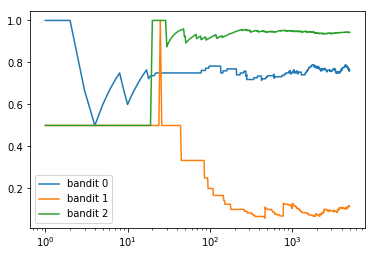

In [10]:
for i in range(expectations.shape[1]):
    plt.plot(expectations[:, i], label=f'bandit {i}')

plt.xscale('log')
plt.legend()

In [11]:
print_bandit_probs(bandits)

[0.8466738701415769, 0.11617319084668587, 0.9461133457244502]


### Gaussian Bandits

Instead of bandits with a winning probability we can have bandits that return values from a gaussian distribution.

In [12]:
class GaussianBandit:
    def __init__(self, mean=0, std=1, init_expectation=0):
        self.mean = mean
        self.std = std
        self.expectation = init_expectation
        self.n = 0
        self.results = []
        
    def update_expectation(self, result):
        self.expectation = (1 - 1 / self.n) * self.expectation + 1 / self.n * result
        
    def pull(self):
        result = np.random.randn() * self.std + self.mean
        
        self.n += 1
        self.update_expectation(result)
        
        self.results.append(result)
        return result

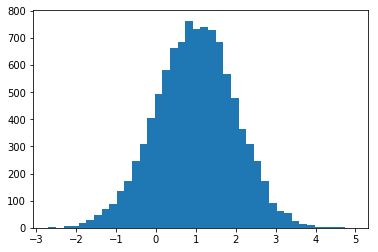

In [13]:
bandit = GaussianBandit(mean=1)

plt.hist([bandit.pull() for _ in range(10000)], bins=40)
plt.show()

### Find best epsilon

Setup: initialize a few gaussian bandits and play them for a fixed number of rounds. Keep track of the total wins. Then change the epsilon value.

Hypothesis: the best epsilon will depend on the number of bandits, the number of rounds played, and the means of the bandits.

In [14]:
def evaluate_epsilon(bandit_means, epsilon, num_trials):
    # setup bandits
    bandits = [GaussianBandit(mean) for mean in bandit_means]
    
    # capture performance metrics
    num_bandits = len(bandit_means)
    expectations = np.zeros([num_trials, num_bandits])
    gains = np.zeros([num_trials])

    # run evaluation
    for i in range(num_trials):
        if np.random.random() < epsilon:
            bandit = np.random.choice(bandits)
        else:
            bandit = bandits[np.argmax([bandit.expectation for bandit in bandits])]

        gains[i] = bandit.pull()
        expectations[i] = [bandit.expectation for bandit in bandits]
    
    return gains, expectations.copy()

#### a single run

In [15]:
epsilon = 0.1
bandit_means = [0, 1, 3]
num_trials = 10000

gains, expectations = evaluate_epsilon(bandit_means, epsilon, num_trials)

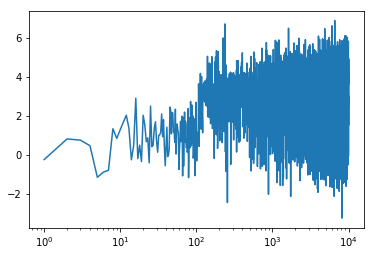

In [16]:
plt.plot(gains)
plt.xscale('log')

In [17]:
gains.sum()

28176.901631798595

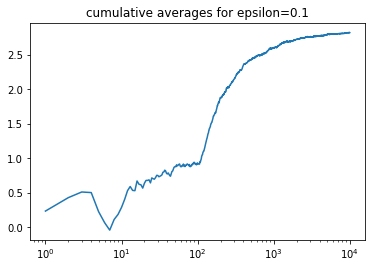

In [18]:
cum_avg_epsilon = (gains.cumsum() / (np.arange(num_trials) + 1))[:]

plt.plot(cum_avg_epsilon)
plt.title(f'cumulative averages for epsilon={epsilon}')
plt.xscale('log')

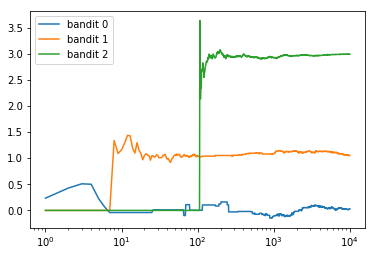

In [19]:
for i in range(expectations.shape[1]):
    plt.plot(expectations[:, i], label=f'bandit {i}')
    
plt.legend()
plt.xscale('log')
plt.show()

#### exploring different epsilon values

In [20]:
bandit_means = [i * 5 for i in range(4)]
num_epsilon_values = 100
num_trials = 1000

In [21]:
epsilons = np.zeros(num_epsilon_values)
gains = np.zeros(num_epsilon_values)

for i in range(num_epsilon_values):
    epsilon = np.random.random() * 0.2
    gain_sequence, _ = evaluate_epsilon(bandit_means, epsilon, num_trials)
    
    epsilons[i] = epsilon
    gains[i] = gain_sequence.sum()

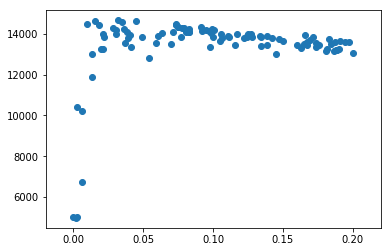

In [22]:
plt.scatter(epsilons, gains)

In [23]:
best_epsilons = epsilons[np.argsort(gains)[::-1][:5]]
best_epsilons

array([ 0.03237501,  0.04455137,  0.0155765 ,  0.03501746,  0.07315945])

In [24]:
best_epsilons.mean()

0.040135959213291196

In [25]:
worst_epsilons = epsilons[np.argsort(gains)[:5]]
worst_epsilons

array([ 0.00168626,  0.00016127,  0.00235214,  0.00635626,  0.006077  ])

In [26]:
worst_epsilons.mean()

0.0033265850673081278

#### some findings

- an epsilon value of 0.02 to 0.03 seems to get the highest gain in general
- I did not find best epsilon values above 0.1
- if the bandit means are really close a higher epsilon seems to be of help (around 0.08)
- if there are a *lot* of bandits a higher epsilon, closer to 0.1, seems better
- the best and the worst epsilons are very close together! Looks like a gamble.
- gains rise quickly between epsilons from 0 to 0.03
- it is probably better to select a good but safe epsilon (around 0.05 or higher) instead of going for the best.

### Optimistic initatial values

Instead of epsilon-greedy, set initial values high and adapt to lower over time.

In [27]:
def evaluate_optimistic_initial_values(bandit_means, initial_value=100, num_trials=1000):
    # setup bandits
    bandits = [GaussianBandit(mean, init_expectation=initial_value) for mean in bandit_means]
    
    # capture performance metrics
    num_bandits = len(bandit_means)
    expectations = np.zeros([num_trials, num_bandits])
    gains = np.zeros([num_trials])

    # run evaluation
    for i in range(num_trials):
        expectations[i] = [bandit.expectation for bandit in bandits]
        
        bandit = bandits[np.argmax([bandit.expectation for bandit in bandits])]
        gains[i] = bandit.pull()
    
    return gains, expectations.copy(), bandits

In [28]:
bandit_means = [0, 1, 3]
num_trials = 10000
initial_value = 10

gains, expectations, bandits = evaluate_optimistic_initial_values(bandit_means, initial_value, num_trials)

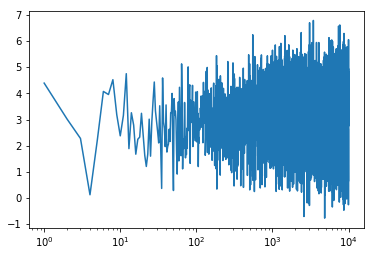

In [29]:
plt.plot(gains)
plt.xscale('log')

In [30]:
gains.sum()

30014.956513530313

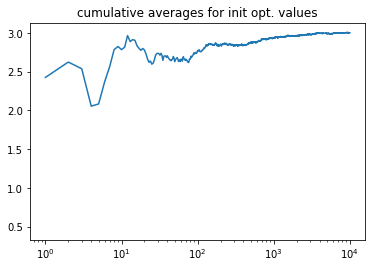

In [31]:
cum_avg_optimistic = (gains.cumsum() / (np.arange(num_trials) + 1))[:]

plt.plot(cum_avg_optimistic)
plt.title(f'cumulative averages for init opt. values')
plt.xscale('log')

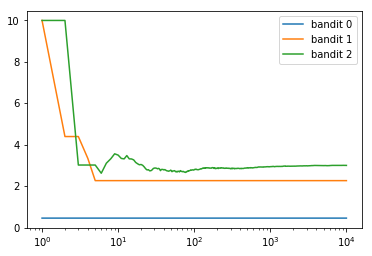

In [32]:
for i in range(expectations.shape[1]):
    plt.plot(expectations[:, i], label=f'bandit {i}')
    
plt.legend()
plt.xscale('log')
plt.show()

#### comparing epsilon-greedy cumulative averages with optimistic

optimistic initial values strategy does better than epsilon-greedy, esp. in the long run. This is because epsilon-greedy does not stop playing subobtimally with a small probabiliy.

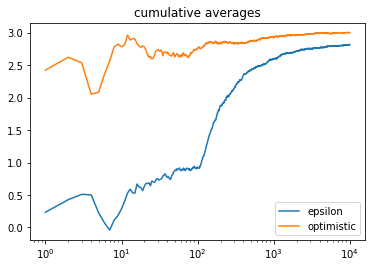

In [33]:
plt.plot(cum_avg_epsilon, label='epsilon')
plt.plot(cum_avg_optimistic, label='optimistic')
plt.title(f'cumulative averages')
plt.legend()
plt.xscale('log')

### UCB1: upper confidence bounds

Using Chernoff-Hoeffding inequality, update the bandit-expectation with the upper confidence bound - which gets smaller as a bandit gets played more often.

In [34]:
def evaluate_ucb(bandit_means, num_trials=1000):
    # setup bandits
    bandits = [GaussianBandit(mean) for mean in bandit_means]
    
    # prepare capturing performance metrics
    num_bandits = len(bandit_means)
    expectations = np.zeros([num_trials, num_bandits])
    gains = np.zeros([num_trials])

    # run evaluation
    for i in range(num_trials):
        expectations[i] = [bandit.expectation for bandit in bandits]
        
        augmented_expectations = [
            bandit.expectation + np.sqrt(2 * (np.log(i + 1)) / (bandit.n + 1e-8)) for bandit in bandits]
        bandit = bandits[np.argmax(augmented_expectations)]
        gains[i] = bandit.pull()
    
    return gains, expectations.copy(), bandits

In [35]:
bandit_means = [0, 1, 3]
num_trials = 10000

gains, expectations, bandits = evaluate_ucb(bandit_means, num_trials)

In [36]:
gains.sum()

29888.909219564288

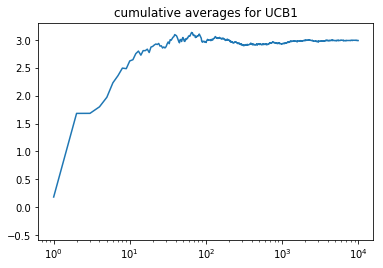

In [37]:
cum_avg_ucb = (gains.cumsum() / (np.arange(num_trials) + 1))[:]

plt.plot(cum_avg_ucb)
plt.title(f'cumulative averages for UCB1')
plt.xscale('log')

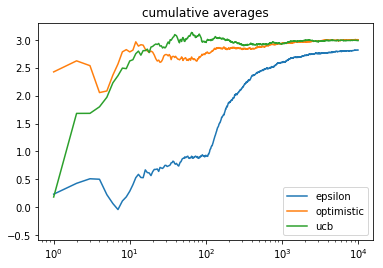

In [38]:
plt.plot(cum_avg_epsilon, label='epsilon')
plt.plot(cum_avg_optimistic, label='optimistic')
plt.plot(cum_avg_ucb, label='ucb')

plt.title('cumulative averages')
plt.legend()
plt.xscale('log')

### Thompson sampling / Bayesian method

#### Bernoulli bandit

Look at bernoulli-bandits again: at start we have to assume a probability distribution for p ~ Unif(0, 1). As we go along, this assumption changes with more trials and the estimate will also get better. Use a Beta-distribution to model this progress.

This approach seems to work particularly well with Bernoulli distributions (the beta-distribution is conjugate to Bernoulli).

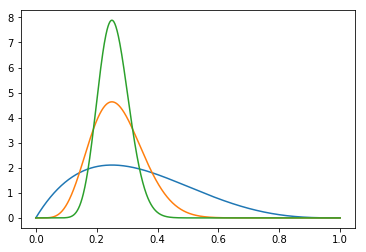

In [39]:
a = 1
b = 1

num_ones = 1
num_zeros = 3

plt.plot(np.linspace(0, 1, 1000), beta.pdf(np.linspace(0, 1, 1000), a + num_ones, b + num_zeros))
plt.plot(np.linspace(0, 1, 1000), beta.pdf(np.linspace(0, 1, 1000), a + num_ones * 6, b + num_zeros * 6))
plt.plot(np.linspace(0, 1, 1000), beta.pdf(np.linspace(0, 1, 1000), a + num_ones * 18, b + num_zeros * 18))

Now for each bandit, update the beta-distribution of the win-probability with every trial. To pick a bandit for the current iteration, sample from the distribution and choose the bandit which had the highest sample.

In [40]:
class BernoulliBandit:
    def __init__(self):
        self.num_wins = 0
        self.n = 0
        self.p = np.random.random()
        
    def get_a(self):
        return 1 + self.num_wins
    
    def get_b(self):
        return 1 + self.n - self.num_wins
    
    def get_expectation(self):
        return beta.mean(self.get_a(), self.get_b())
        
    def sample(self, n):
        '''returns a sample from the current prior (beta-distribution)'''
        return beta.rvs(self.get_a(), self.get_b(), size=n)
    
    def get_p(self):
        return self.p
    
    def update(self, result):
        self.n += 1
        self.num_wins += result
        
    def pull(self):
        result = 1 if np.random.random() < self.p else 0
        self.update(result)
        
        return result

Text(0.5,1,'expectations for thompson sampling')

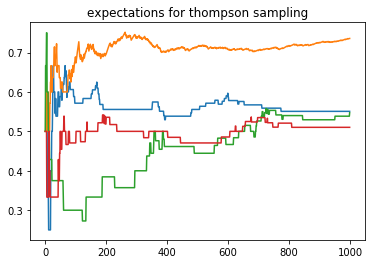

In [41]:
def evaluate_thompson_bernoulli(num_bandits=3, sample_size=10, num_trials=1000):
    # setup bandits
    bandits = [BernoulliBandit() for _ in range(num_bandits)]
    
    # prepare capturing performance metrics
    expectations = np.zeros([num_trials, num_bandits])
    gains = np.zeros([num_trials])

    # run evaluation
    for i in range(num_trials):
        expectations[i] = [bandit.get_expectation() for bandit in bandits]
        
        max_samples = [bandit.sample(sample_size).max() for bandit in bandits]
        bandit = bandits[np.argmax(max_samples)]
        gains[i] = bandit.pull()
    
    return gains, expectations.copy(), bandits

np.random.seed(0)

num_bandits = 4
num_samples = 100
num_trials = 1000

gains, expectations, bandits = evaluate_thompson_bernoulli(num_bandits, num_samples, num_trials)

for i in range(num_bandits):
    plt.plot(expectations[:, i])
    
plt.xscale('linear')
plt.title('expectations for thompson sampling')    # setup bandits

In [42]:
np.random.seed(0)

num_bandits = 4
num_samples = 100
num_trials = 1000

gains, expectations, bandits = evaluate_thompson_bernoulli(num_bandits, num_samples, num_trials)

Text(0.5,1,'expectations for thompson sampling')

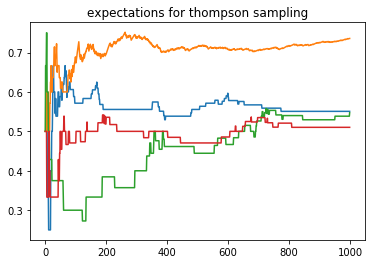

In [43]:
for i in range(num_bandits):
    plt.plot(expectations[:, i])
    
plt.xscale('linear')
plt.title('expectations for thompson sampling')

In [44]:
[bandit.get_p() for bandit in bandits]

[0.5488135039273248,
 0.7151893663724195,
 0.6027633760716439,
 0.5448831829968969]

#### Gaussian bandit

The conjugate prior to a normal distribution is again a normal distribution. This means that the prior that estimates the mean will have to be a normal. Some algebra will find the mean and variance of the posterior distribution:

$$
p(\theta \rvert X) \sim \mathcal{N}(\frac{x \tau + m_0 \lambda_0}{\tau + \lambda_0}, \frac{1}{\tau + \lambda_0})
$$

Here, $x$ and $\tau$ are the parameters of the likelihood, and $m_0$ and $\lambda_0$ belong to the prior.

In [45]:
class GaussianBandit:
    def __init__(self, mean=0, std=1, tau=1):
        # actual mean and std
        self.mean = mean
        self.std = std
        
        # mean and precision of the prior
        self.m = 0
        self.lmbda = 1
        
        # precision of the likelihood
        self.tau = tau
        
    def get_expectation(self):
        return self.m
    
    def update(self, result):
        '''sets the posterior prob after the observation as new prior'''
        lmbda = self.tau + self.lmbda
        m = (result * self.tau + self.m * self.lmbda) / lmbda
        
        self.lmbda = lmbda
        self.m = m
        
    def sample(self, n):
        '''draws n samples (of possible expectations)'''
        return np.random.randn(n) / np.sqrt(self.lmbda) + self.m
        
    def pull(self):
        '''uses the bandit-mean to draw a reward-value'''
        result = np.random.randn() * self.std + self.mean
        self.update(result)
        
        return result

In [46]:
def evaluate_thompson_gaussian(bandit_means, sample_size=10, num_trials=1000):
    # setup bandits
    bandits = [GaussianBandit(mean, tau=0.1) for mean in bandit_means]
    
    # prepare capturing performance metrics
    num_bandits = len(bandit_means)
    expectations = np.zeros([num_trials, num_bandits])
    gains = np.zeros([num_trials])

    # run evaluation
    for i in range(num_trials):
        expectations[i] = [bandit.get_expectation() for bandit in bandits]
        
        max_samples = [bandit.sample(sample_size).max() for bandit in bandits]
        bandit = bandits[np.argmax(max_samples)]
        gains[i] = bandit.pull()
    
    return gains, expectations.copy(), bandits

In [47]:
#np.random.seed(0)

bandit_means = [0, 1, 3]
num_samples = 10
num_trials = 10000

gains, expectations, bandits = evaluate_thompson_gaussian(bandit_means, num_samples, num_trials)

Text(0.5,1,'expectations for thompson sampling (gauss)')

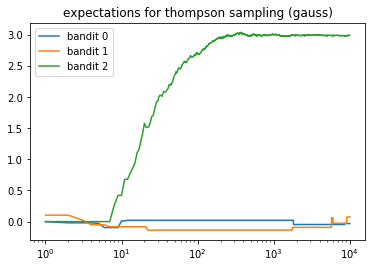

In [48]:
for i in range(len(bandit_means)):
    plt.plot(expectations[:, i], label=f'bandit {i}')
    
plt.xscale('log')
plt.legend()
plt.title('expectations for thompson sampling (gauss)')

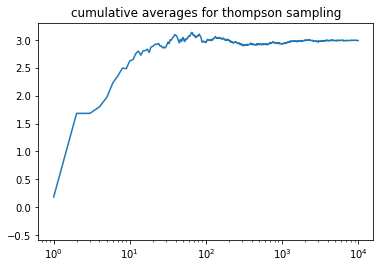

In [49]:
cum_avg_thompson = (gains.cumsum() / (np.arange(num_trials) + 1))[:]

plt.plot(cum_avg_ucb)
plt.title(f'cumulative averages for thompson sampling')
plt.xscale('log')

#### Big comparison of all four strategies

At the end of the day, all methods converge to the same final states except for epsilon-greedy, which starts of slowly and performs more or less subptimally depending on epsilon. One simple solution is to decay epsilong, e.g. with 1/t with each iteration t. 

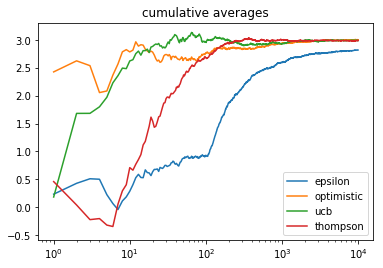

In [50]:
plt.plot(cum_avg_epsilon, label='epsilon')
plt.plot(cum_avg_optimistic, label='optimistic')
plt.plot(cum_avg_ucb, label='ucb')
plt.plot(cum_avg_thompson, label='thompson')

plt.title('cumulative averages')
plt.legend()
plt.xscale('log')